# Tutorial on metasyn-disclosure

In this tutorial, we will show how to use the metasyn disclosure control plugin. It uses the same procedure as the base metasyn [package](https://github.com/sodascience/metasyn/blob/main/examples/advanced_tutorial.ipynb). The output format will be the same: a GMF file will be created with the same parameter types as with the base package. One difference is that not all distributions are implemented by the disclosure plugin. The missing distributions will not be fit by default, but they can be manually set.

In [1]:
from collections import defaultdict

import numpy as np
import polars as pl
from metasyn import MetaFrame, demo_file
from metasyn.provider import DistributionProviderList
from metasyn.distribution import (
    DiscreteUniformDistribution,
    FakerDistribution,
    RegexDistribution,
    MultinoulliDistribution,
)

from metasyncontrib.disclosure import DisclosurePrivacy

## Transforming your data into a polars DataFrame

The first step in creating the metadata is reading and converting your dataset to a polars DataFrame. 

In [2]:
titanic_path = demo_file()
df = pl.read_csv(
    source=titanic_path,
    try_parse_dates=True,
    schema_overrides={"Sex": pl.Categorical, "Embarked": pl.Categorical},
)
df.head()

PassengerId,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,str,f64,str,cat,date,time,datetime[μs],str
1,"""Braund, Mr. Owen Harris""","""male""",22,0,"""A/5 21171""",7.25,null,"""S""",1937-10-28,15:53:04,2022-08-05 04:43:34,null
2,"""Cumings, Mrs. John Bradley (Fl…","""female""",38,0,"""PC 17599""",71.2833,"""C85""","""C""",null,12:26:00,2022-08-07 01:56:33,null
3,"""Heikkinen, Miss. Laina""","""female""",26,0,"""STON/O2. 3101282""",7.925,null,"""S""",1931-09-24,16:08:25,2022-08-04 20:27:37,null
4,"""Futrelle, Mrs. Jacques Heath (…","""female""",35,0,"""113803""",53.1,"""C123""","""S""",1936-11-30,null,2022-08-07 07:05:55,null
5,"""Allen, Mr. William Henry""","""male""",35,0,"""373450""",8.05,null,"""S""",1918-11-07,10:59:08,2022-08-02 15:13:34,null


### A full example with the base package

Below we have the synthesis that uses the base metasyn package so that we can see potential problems with it. For a more detailed explanation of the base package, see our base [tutorial](https://github.com/sodascience/metasyn/blob/main/examples/advanced_tutorial.ipynb).

In [3]:
specs = [
    # we set passengerId to unique
    {"name": "PassengerId", "distribution": {"unique": True}},
    # We create new fake names for the name column
    {"name": "Name", "distribution": FakerDistribution("name")},
    # Fit an exponential distribution based on the data for fare
    {"name": "Fare", "distribution": {"implements": "core.exponential"}},
    # For age we enforce a specific uniform distribution
    {"name": "Age", "distribution": DiscreteUniformDistribution(20, 40)},
    # We know cabin has a specific regular expression
    {"name": "Cabin", "distribution": RegexDistribution(r"[ABCDEF][0-9]{2,3}")},
]

mf = MetaFrame.fit_dataframe(df, var_specs=specs)

print(
    f"Lower bound distribution:  {mf['Married since'].distribution.lower}\n"
    f"Lowest value in dataframe: {df['Married since'].min()}"
)
mf.synthesize(5)

100%|██████████| 13/13 [00:00<00:00, 17.14it/s]

Lower bound distribution:  2022-07-15 12:21:15
Lowest value in dataframe: 2022-07-15 12:21:15


PassengerId,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,str,f64,str,cat,date,time,datetime[μs],null
1,"""Bobby Wells""","""male""",null,0,"""4323""",7.122325,"""A87""","""S""",1927-11-10,17:03:14,2022-08-04 13:54:17,null
2,"""Brandon Rodriguez""","""female""",31,0,"""168815""",25.237585,null,"""S""",1907-11-27,17:32:45,2022-07-25 00:03:49,null
3,"""Gary Patel""","""male""",26,0,"""7791""",21.773873,"""B52""","""S""",1919-04-23,13:49:35,2022-08-09 04:03:03,null
4,"""Robert Chang""","""male""",null,0,"""16908""",2.434371,null,"""S""",1907-12-13,13:08:15,2022-07-16 16:27:47,null
5,"""Christopher Johns""","""male""",38,1,"""320287""",0.920237,null,"""S""",1927-10-28,12:27:26,2022-07-28 02:04:10,null


From the previous results, we can see the problem that can sometimes happen with the base package: the earliest datetime of the "Married since" column gets recorded in the distribution itself, and thus in the resulting GMF file.

### A full example with disclosure

Below is the same example with the metasyn disclosure plugin.

In [4]:
meta_frame = MetaFrame.fit_dataframe(
    df=df,
    var_specs=specs,
    dist_providers="metasyn-disclosure",  # Use the metasyn-disclosure plugin
    privacy=DisclosurePrivacy(),  # Use disclosure control
)
print(
    f"Lower bound distribution:  {meta_frame['Married since'].distribution.lower}\n"
    f"Lowest value in dataframe: {df['Married since'].min()}"
)
meta_frame.synthesize(5)

100%|██████████| 13/13 [00:00<00:00, 58.78it/s]

Lower bound distribution:  2022-07-15 17:12:24
Lowest value in dataframe: 2022-07-15 12:21:15


PassengerId,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked,Birthday,Board time,Married since,all_NA
i64,str,cat,i64,i64,null,f64,str,cat,date,time,datetime[μs],null
0,"""Kathryn Williams""","""female""",26,0,null,4.636532,null,"""S""",1909-10-15,17:10:56,2022-08-11 19:28:07,null
1,"""Cynthia Acevedo""","""female""",32,1,null,83.37944,"""C81""","""S""",1907-10-11,11:33:49,2022-07-29 19:25:06,null
2,"""Sandra Baker""","""male""",26,0,null,14.133774,null,"""C""",1935-07-18,13:57:18,2022-07-30 05:07:22,null
3,"""Jessica Rivas""","""male""",30,0,null,57.559711,"""E294""","""S""",1937-01-22,15:47:00,2022-08-11 07:29:54,null
4,"""Margaret Miller""","""female""",32,2,null,3.902778,null,"""S""",1912-10-23,16:34:09,null,null


As you can see, the disclosure plugin fixes the privacy concern present in the base metasyn package: the lower bound of the distribution is no longer equal to the lowest value in the dataframe.

## Single outliers

Below we will look at what happens to our parameters if we add a single new value (outlier) to the data. We do this for both the base metasyn implementation and the disclosure control implementation. We expect that following the rules of disclosure control, a single outlier should have a smaller (and limited) effect on the results than with the base metasyn implementation.

In [5]:
# If you get an error, install matplotlib with `pip install matplotlib`
from matplotlib import pyplot as plt


Define the plotting function.

In [6]:
def plot_outliers(dist_type, series_size=50):
    dist_providers = DistributionProviderList(["builtin", "metasyn-disclosure"])
    disc_distributions = dist_providers.get_distributions(
        var_type=dist_type, privacy=DisclosurePrivacy()
    )

    for disc_class in disc_distributions:
        if issubclass(disc_class, MultinoulliDistribution):
            continue
        base_class = dist_providers.find_distribution(disc_class.implements, disc_class.var_type)

        dist = base_class.default_distribution()
        series = pl.Series([dist.draw() for _ in range(series_size)])
        clean_base_param = base_class.fit(series).to_dict()["parameters"]
        clean_disc_param = disc_class.fit(series).to_dict()["parameters"]

        base_param = defaultdict(lambda: [])
        disc_param = defaultdict(lambda: [])

        def _add(parameters, param, new_val):
            for key, val in param.items():
                parameters[key].append(val)
            parameters["new_val"].append(new_val)

        for new_val in np.linspace(-100, 100, 51):
            new_series = series.extend_constant(new_val, 1)
            base_dist = base_class.fit(new_series)
            disc_dist = disc_class.fit(new_series)
            _add(base_param, base_dist.to_dict()["parameters"], new_val)
            _add(disc_param, disc_dist.to_dict()["parameters"], new_val)

        for param in base_param:
            if param == "new_val":
                continue
            plt.plot(
                base_param["new_val"],
                np.array(base_param[param]) - clean_base_param[param],
                label="base",
            )
            plt.plot(
                disc_param["new_val"],
                np.array(disc_param[param]) - clean_disc_param[param],
                label="disclosure",
            )
            plt.title(f"{disc_class.__name__}: {param}")
            plt.ylabel("Difference between dist with and without outlier")
            plt.xlabel("Value of the outlier")
            plt.legend()
            plt.show()

### Graphs for all continuous distributions

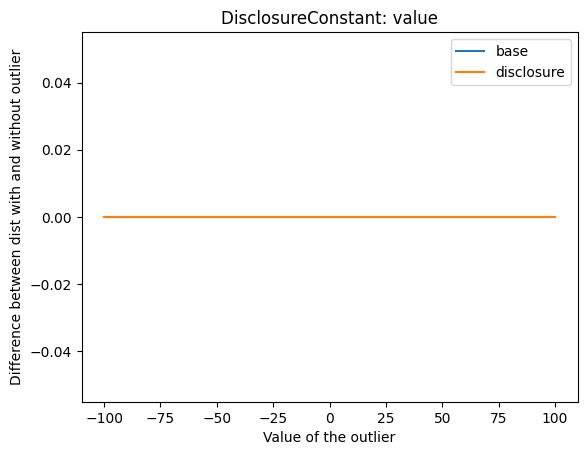

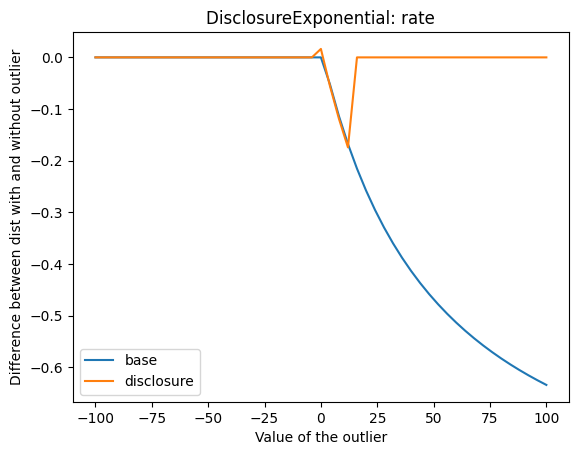

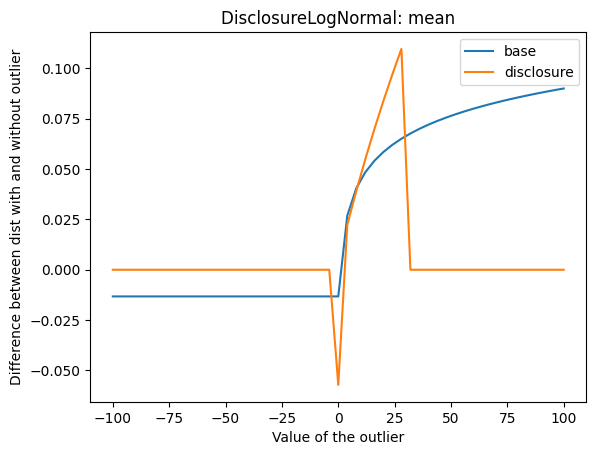

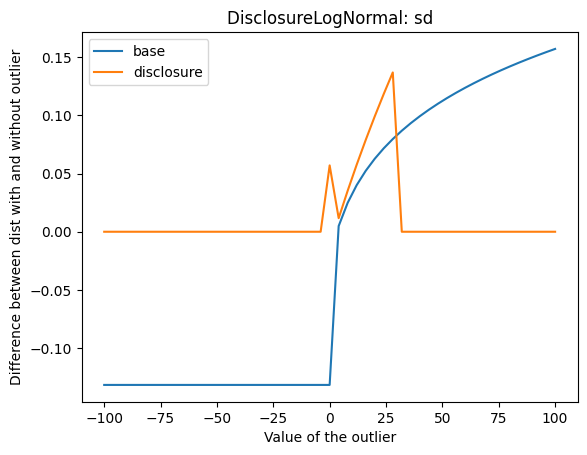

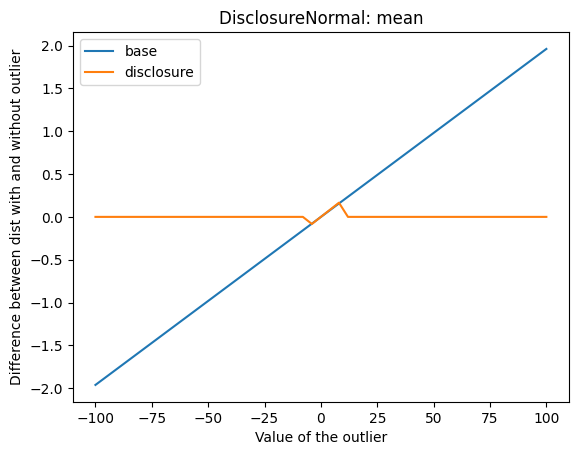

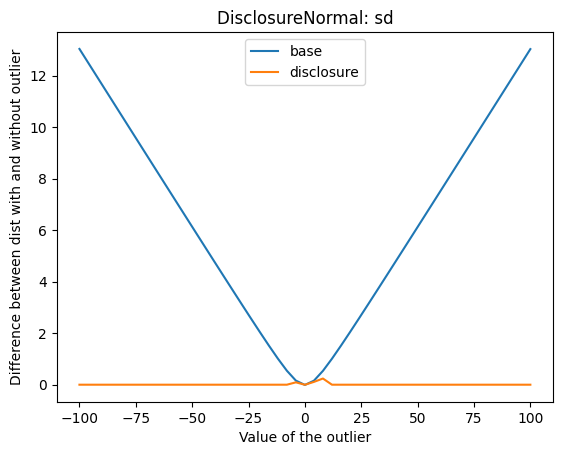

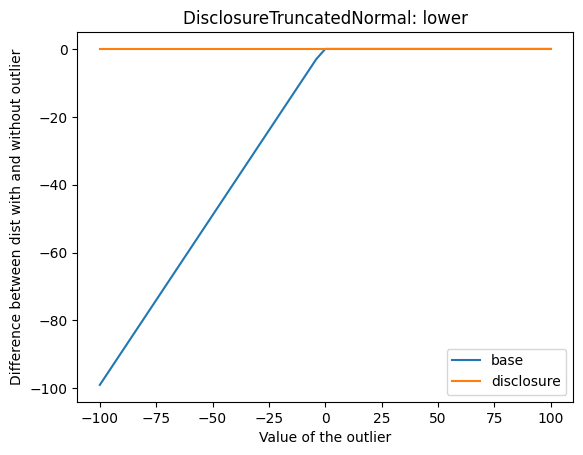

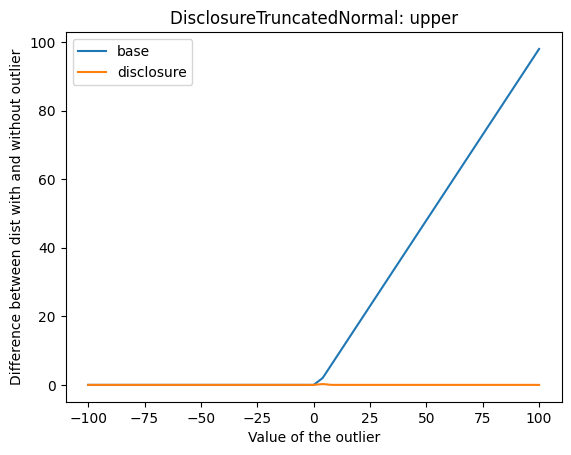

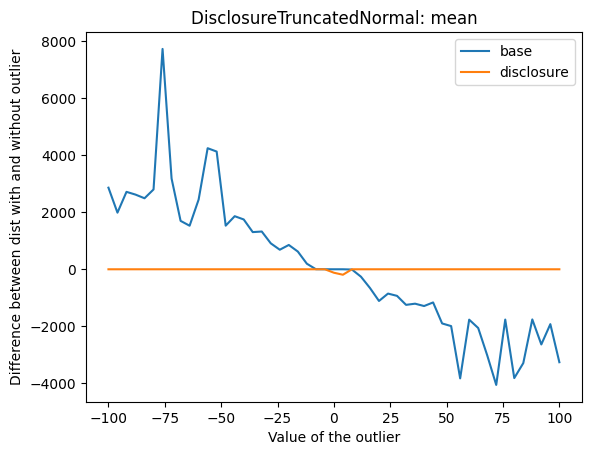

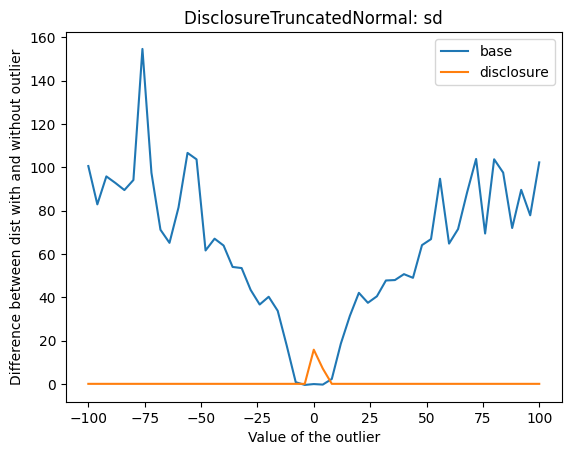

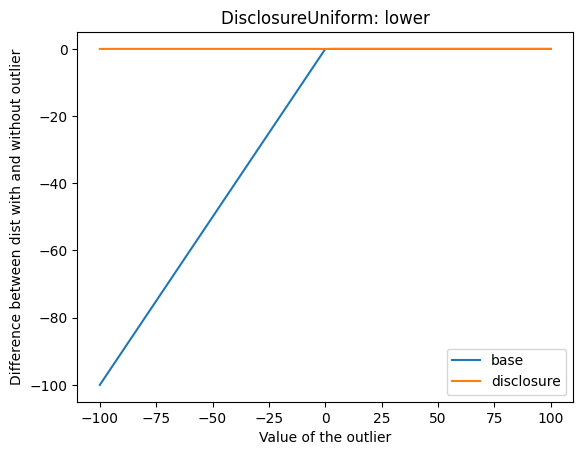

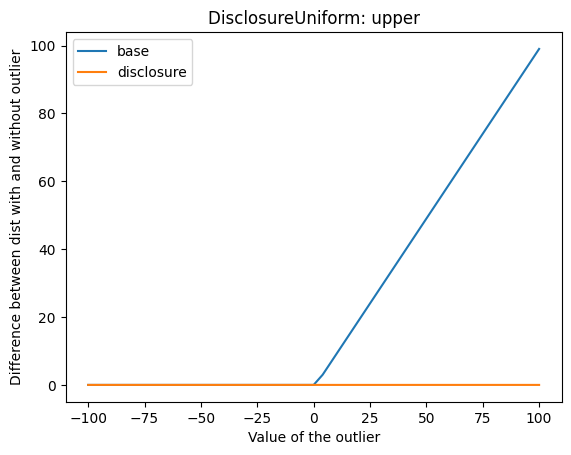

In [7]:
plot_outliers("continuous")

As we can see, the effect from outliers is much reduced compared to the baseline implementation. For all of the distributions, the change in the result is much smaller when an outlier is added.

### Graphs for all discrete distributions

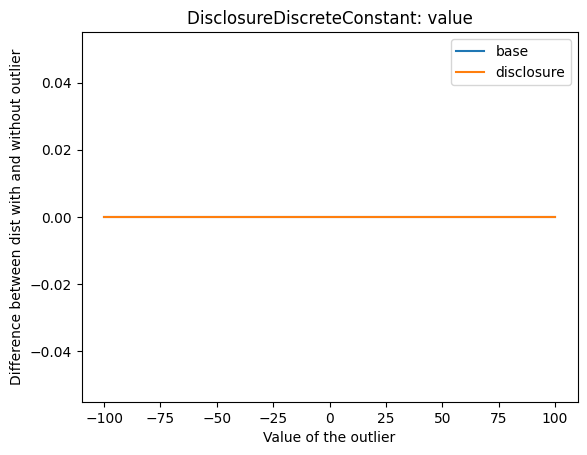

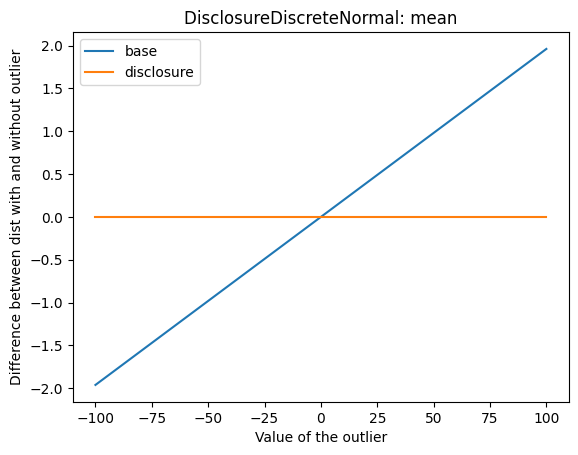

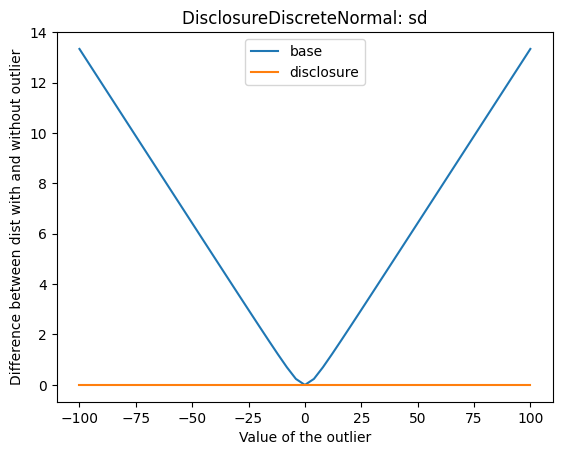

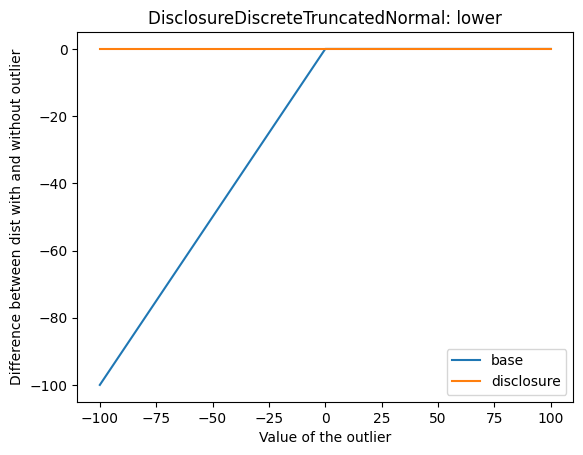

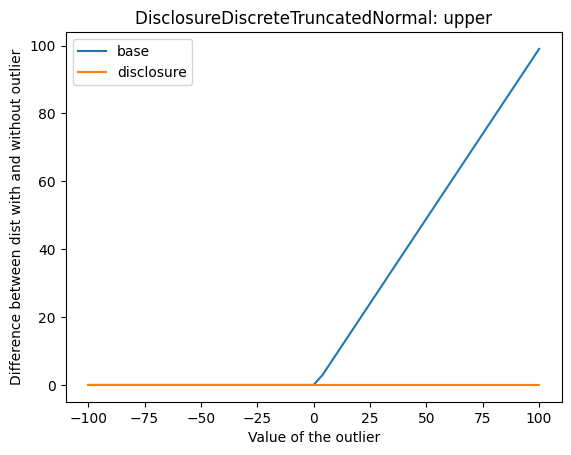

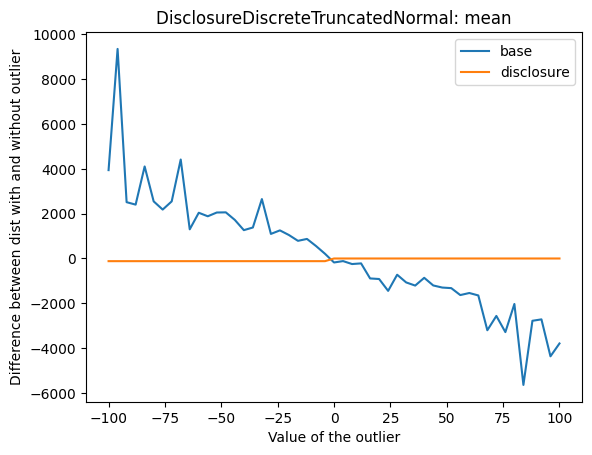

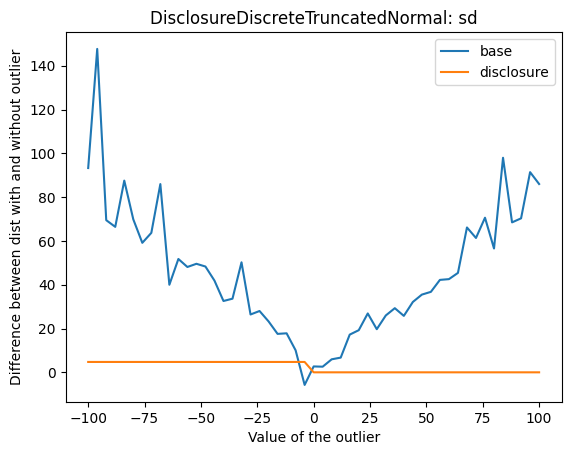

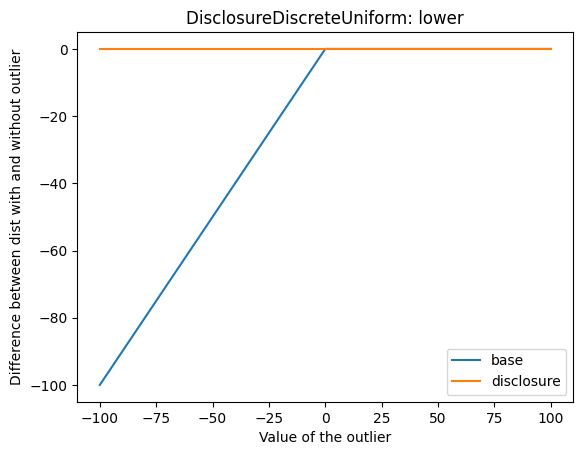

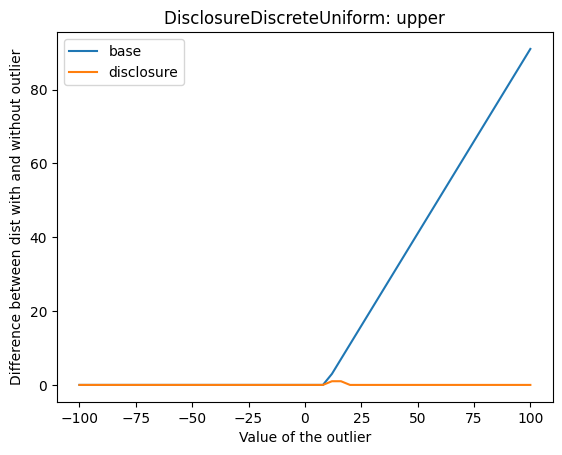

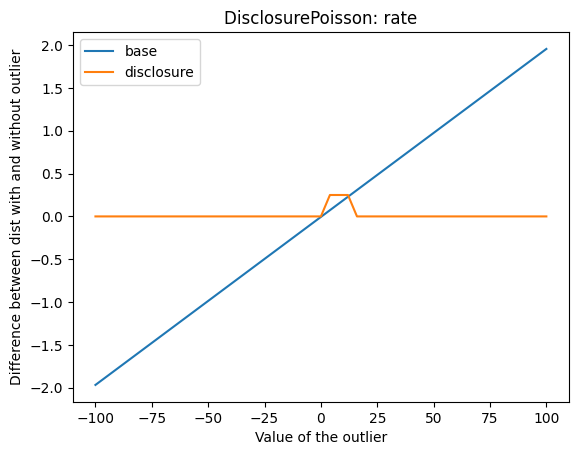

In [8]:
plot_outliers("discrete")

The same is true for the discrete distributions, only a localized effect is present.